# Planar Homography

## Imports

In [110]:
from math import log10, sqrt
import cv2
import numpy as np
import matplotlib.pyplot as plt
import lpips
import torch
import torchvision.transforms as transforms
from torch.nn.functional import normalize
from collections import defaultdict
import warnings
from sklearn.cluster import KMeans


## Auxiliar functions

In [111]:
def get_intersection(line1, line2):
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([[np.cos(theta1), np.sin(theta1)],
                 [np.cos(theta2), np.sin(theta2)]])
    b = np.array([[rho1], [rho2]])
    x, y = np.linalg.solve(A, b)
    x, y = int(x), int(y)
    return (x, y)

In [112]:
def order_points(pts):
    '''Rearrange coordinates to order:
       top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left point will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()

In [113]:
def psnr_eval(gt, homog):
    mse = np.mean((gt - homog) ** 2)
    if (mse == 0):
        # MSE is zero means no noise is present in tl
        # therefore psnr have no importance
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr


In [114]:
def lpips_eval(gt, homog):
    # prevent warnings to terminal output
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=UserWarning)

    # best forward scores
    loss_fn_alex = lpips.LPIPS(net='alex')

    # define transform to convert the image to tensor
    transform = transforms.ToTensor()

    # convert the image to PyTorch tensor
    img0 = transform(gt)
    img1 = transform(homog)

    # normalize values between -1 and 1
    mean0, std0, var0 = torch.mean(img0), torch.std(img0), torch.var(img0)
    mean1, std1, var1 = torch.mean(img1), torch.std(img1), torch.var(img1)

    img0 = (img0-mean0)/std0
    img1 = (img1-mean1)/std1

    # passing images to LPIPS model, getting it's output
    d = loss_fn_alex.forward(img0, img1)
    return d.detach().numpy()[0][0][0][0]


In [115]:
# https://stackoverflow.com/questions/46565975/find-intersection-point-of-two-lines-drawn-using-houghlines-opencv

def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """Groups lines based on angle with k-means.

    Uses k-means on the coordinates of the angle on the unit circle
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = np.array([line[0][1] for line in lines])
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                   for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in enumerate(lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return segmented


In [116]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Return closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]


In [117]:
def segmented_intersections(lines):
    """Finds the intersections between groups of lines"""

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2))

    return intersections


### Read and display original image

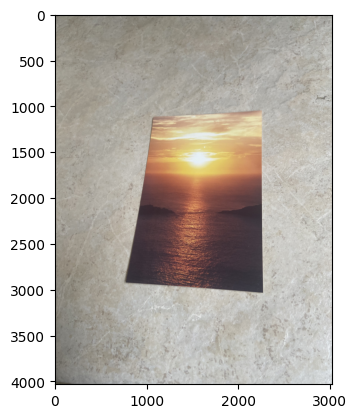

In [118]:
original = cv2.imread('../img/foto2_cap1.jpg')
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
gt = cv2.imread('../img/foto2_gt.jpg')
gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
plt.imshow(original)
plt.show()

In [119]:
h, w, c = original.shape
print('original dimensions')
print(f'image height: {h}, image width: {w}, color channels: {c}')

original dimensions
image height: 4032, image width: 3024, color channels: 3


### Resize to workable dims

In [120]:
dim_limit = 1080
max_dim = max(original.shape[:2])
if max_dim > dim_limit:
    resize_scale = dim_limit / max_dim
    original = cv2.resize(original, None, fx=resize_scale, fy=resize_scale)

In [121]:
h, w, c = original.shape
gt = cv2.resize(gt, (w, h))
print('resized dimensions')
print(f'image height: {h}, image width: {w}, color channels: {c}')

resized dimensions
image height: 1080, image width: 810, color channels: 3


### Image transforms and morph ops

In [122]:
# convert image to grayscale/blurred versions
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image to create a binary image
ret, thresh = cv2.threshold(
    blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# perform morphological transformations to remove noise
kernel = np.ones((24, 24), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)

### Background and foreground analysis

In [123]:
# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=35)

# find sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# find unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# add one to all labels so that sure background is not 0, but 1
markers = markers+1

# mark the region of unknown with zero
markers[unknown == 255] = 0

### Watershed

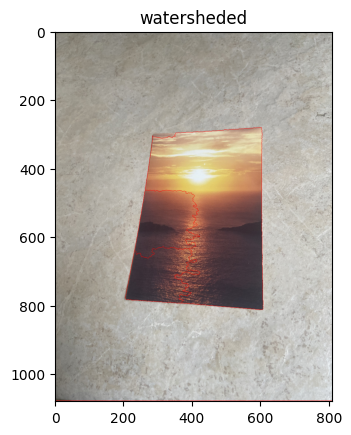

In [124]:
watersheded = original.copy()
markers = cv2.watershed(watersheded, markers)
watersheded[markers == -1] = [255, 0, 0]
plt.imshow(watersheded)
plt.title('watersheded')
plt.show()

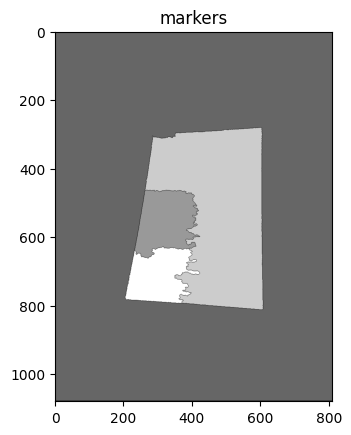

In [125]:
plt.imshow(markers, cmap='gray')
plt.title('markers')
plt.show()

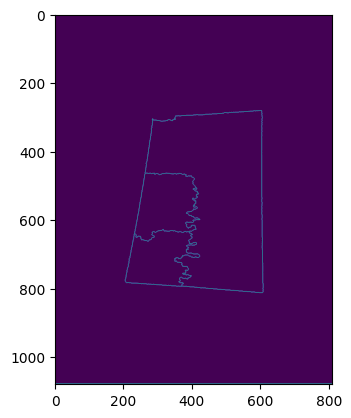

In [126]:
# generate mask image
mask = np.zeros(original.shape[:2], np.uint8)
mask[markers == -1] = 255
plt.imshow(mask)
plt.show()

### Hough lines

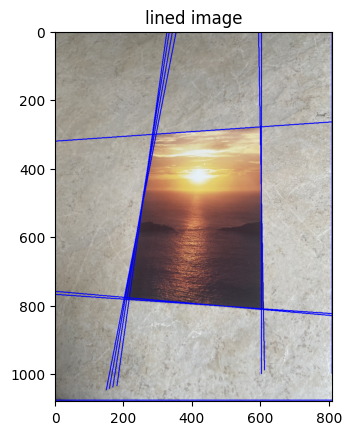

In [127]:
#  perform hough line transform over the mask
lines = cv2.HoughLines(mask, 2, np.pi/180, 150)

# draw lines on the image
lined_img = original.copy()
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(lined_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

# show the image with the lines drawn on it
plt.imshow(lined_img)
plt.title('lined image')
plt.show()


In [128]:
segmented = segment_by_angle_kmeans(lines)
intersections = segmented_intersections(segmented)


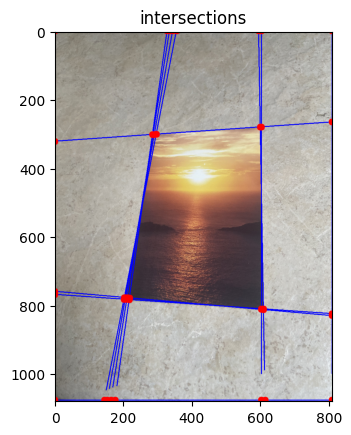

In [129]:
corners = lined_img.copy()
for point in intersections:
    corners = cv2.circle(corners, point[0], radius=10, color=(255,0,0), thickness=-1)

plt.imshow(corners)
plt.title('intersections')
plt.show()

In [130]:
new_points = []
for point in intersections:
    if point[0].count(-1):
        pass
    else:
        new_points.append(point[0])

In [131]:
final_points = []

# removing outliers closest to image borders
for point in new_points:
    point_w = point[0]
    point_h = point[1]
    if point_w > ((w * 94) / 100) or point_h > ((h * 94) / 100):
        pass
    else:
        final_points.append(point)

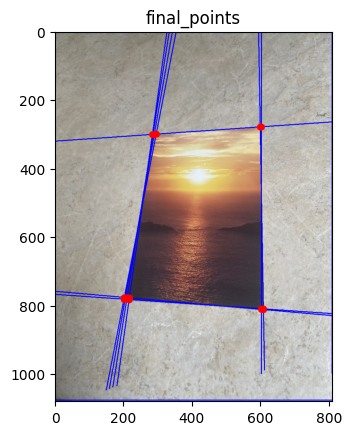

In [132]:
corners = lined_img.copy()
for point in final_points:
    corners = cv2.circle(
        corners, point, radius=10, color=(255, 0, 0), thickness=-1)

plt.imshow(corners)
plt.title('final_points')
plt.show()

#### K-means

In [133]:
points = []
for point in final_points:
    points.append(point)

kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto").fit(points)
cornered_img = original.copy()
centers = list(kmeans.cluster_centers_.astype(int))
centers = [list(point) for point in centers]
# rearranging corners order
corners = order_points(centers)

for point in centers:
    cornered_img = cv2.circle(
        cornered_img, point, radius=10, color=(255, 0, 0), thickness=-1)


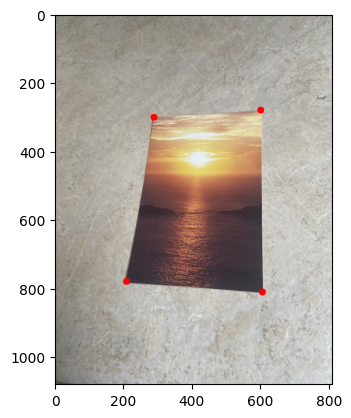

In [134]:
plt.imshow(cornered_img)
plt.show()

## Finding destination co-ordinates

In [135]:
(tl, tr, br, bl) = corners

# finding max width
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))

# finding max height
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))

# final destination coords
destination_corners = [
    [0, 0],
    [maxWidth, 0],
    [maxWidth, maxHeight],
    [0, maxHeight]]

print(destination_corners)

[[0, 0], [397, 0], [397, 531], [0, 531]]


## Homography

In [136]:
# getting homog
homography = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
# warping
final = cv2.warpPerspective(original, np.float32(homography), (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)

## Results

### Original vs Processed

Text(0.5, 1.0, 'Scanned Form')

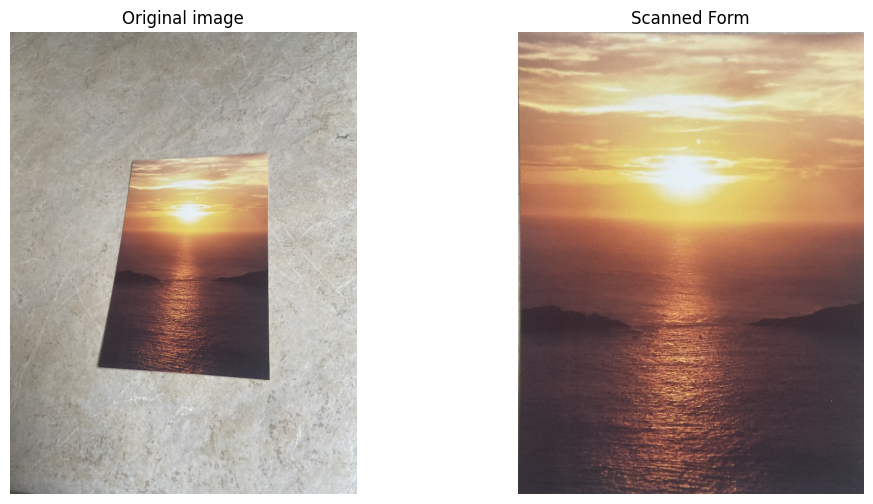

In [137]:
# Display results
plt.figure(figsize=[12, 6])
plt.subplot(121)
plt.imshow(original)
plt.axis('off')
plt.title("Original image")
plt.subplot(122)
plt.imshow(final)
plt.axis('off')
plt.title("Scanned Form")


### Ground Truth vs Processed

In [138]:
width, height, channels = final.shape
gt = cv2.resize(gt, (height, width))

Text(0.5, 1.0, 'Scanned Form')

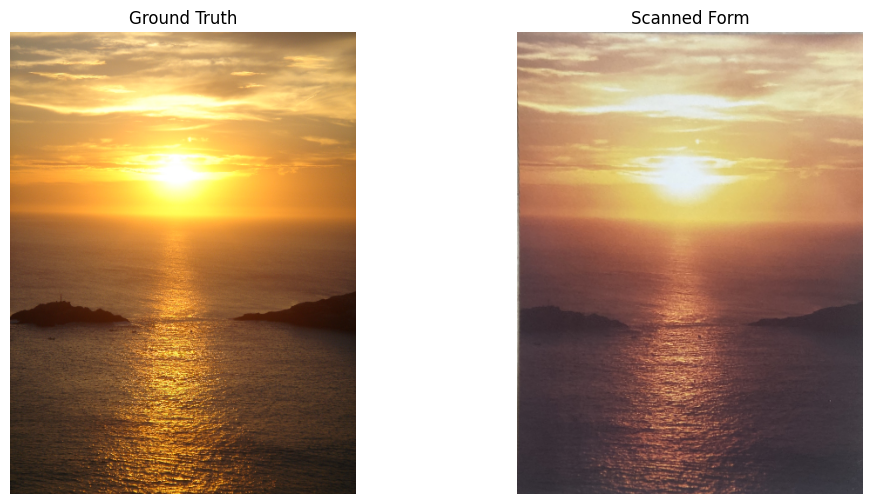

In [139]:
# Display results
plt.figure(figsize=[12, 6])
plt.subplot(121)
plt.imshow(gt)
plt.axis('off')
plt.title("Ground Truth")
plt.subplot(122)
plt.imshow(final)
plt.axis('off')
plt.title("Scanned Form")

## Evaluations

### PSNR

In [140]:
value = psnr_eval(gt, final)
print(f'PSNR value is {value} dB')

PSNR value is 28.113622253315384 dB


### LPIPS

In [141]:
distance = lpips_eval(gt, final)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/lmceschini/Documents/ufrgs/planar_homography/.venv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [142]:
print(f'LPIPS distance between images: {distance}')

LPIPS distance between images: 0.31484100222587585
